<a href="https://colab.research.google.com/github/Soumya080/numpy-ml-foundations/blob/main/linear_regression/day_9_dataset_sigmoid_forward_pass_and_visuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Untrained probs: min, max, mean -> 0.49800936797854417 0.5129974756935303 0.5057466680930971
Untrained logits z: min, max, mean -> -0.007962570156143534 0.05200161803328589 0.022988981236192498
Trained theta: [ 2.06521763 -5.20808587  0.4187084 ]
Train BCE: 0.16498309988960608 Test BCE: 0.20858891222881246
Train probs min,max: 2.7580615986266254e-05 0.9999943700250858
Test  probs min,max: 1.3517700513842117e-05 0.9999858117429362
Train acc: 0.9291666666666667 Test acc: 0.9333333333333333


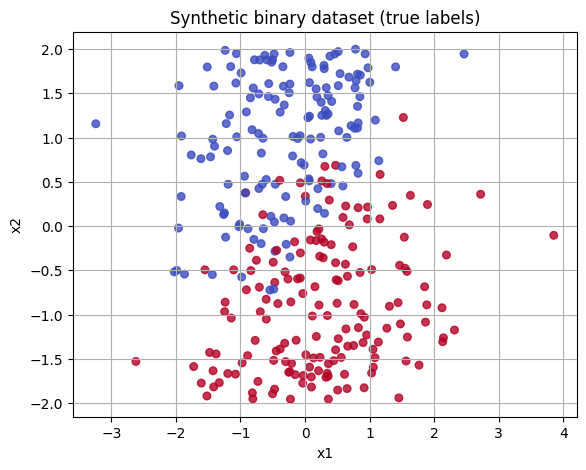

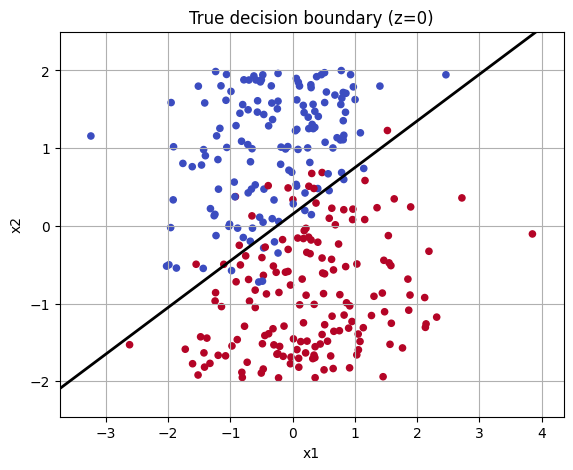

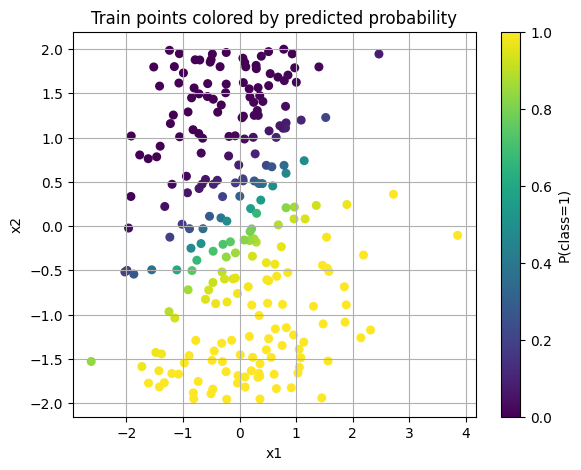

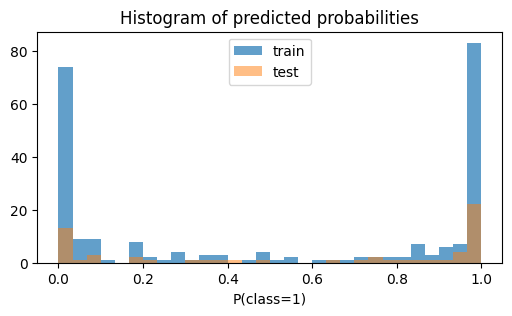

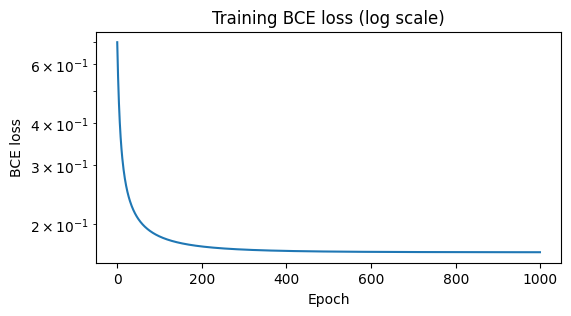

Near-boundary count (train): 8
idx 27 x=(0.376,0.294) prob=0.550 label=1
idx 39 x=(0.197,0.198) prob=0.557 label=0
idx 75 x=(0.822,0.597) prob=0.463 label=0
idx 118 x=(1.143,0.739) prob=0.482 label=0
idx 124 x=(0.587,0.454) prob=0.491 label=0
idx 152 x=(-0.680,-0.198) prob=0.515 label=0
idx 181 x=(-0.857,-0.250) prob=0.476 label=1
idx 184 x=(-0.223,0.056) prob=0.486 label=0


In [ ]:
# Day-9: Logistic Regression (full day) — Sigmoid, Forward Pass, Dataset, Training, Visuals
import os
import numpy as np
import matplotlib.pyplot as plt

# Configuration
np.random.seed(42)
n_samples = 300
noise_sigma = 0.8
w_true = np.array([1.2, -2.0])   # true weights (w1, w2)
b_true = 0.3                     # true bias
test_ratio = 0.2

save_visuals = True
os.makedirs("visuals", exist_ok=True)

#  1) Numerically-stable sigmoid (vectorized)
def sigmoid(z):
    z = np.array(z, dtype=float)
    return np.where(
        z >= 0,
        1.0 / (1.0 + np.exp(-z)),
        np.exp(z) / (1.0 + np.exp(z))
    )

# 2) Synthetic dataset (true linear rule + noise)
# Feature distributions: x1 ~ N(0,1), x2 ~ U(-2,2)
x1 = np.random.randn(n_samples)
x2 = np.random.uniform(-2, 2, n_samples)
X = np.column_stack([x1, x2])

# True noiseless score and noisy score
z_no_noise = X @ w_true + b_true
z_noisy = z_no_noise + np.random.randn(n_samples) * noise_sigma

# Labels (binary)
y = (z_noisy > 0).astype(int).reshape(-1, 1)

#  3) Train/test split and scaling
split_idx = int((1 - test_ratio) * n_samples)
X_train = X[:split_idx]
X_test  = X[split_idx:]
y_train = y[:split_idx]
y_test  = y[split_idx:]

# Scale using train stats
x_mean = X_train.mean(axis=0)
x_std  = X_train.std(axis=0) + 1e-12
X_train_scaled = (X_train - x_mean) / x_std
X_test_scaled  = (X_test  - x_mean) / x_std

# 4) Design matrix builder (bias as last column)
def build_design_matrix(X_features):
    Xf = np.asarray(X_features, dtype=float)
    if Xf.ndim == 1:
        Xf = Xf.reshape(-1, 1)
    ones = np.ones((Xf.shape[0], 1))
    return np.hstack([Xf, ones])   # columns: [x1, x2, ..., bias]

Xd_train = build_design_matrix(X_train_scaled)
Xd_test  = build_design_matrix(X_test_scaled)

#  5) Forward pass
def forward_logistic(X_design, theta):
    theta = np.array(theta, dtype=float).reshape(-1, 1)
    z = X_design @ theta
    p = sigmoid(z)
    return z, p

#  6) Initialize theta sensibly
n_features = Xd_train.shape[1] - 1
theta0 = np.random.randn(n_features + 1, 1) * 0.01  # small random init

# Quick forward-check (untrained)
z0, p0 = forward_logistic(Xd_train, theta0)
print("Untrained probs: min, max, mean ->", float(p0.min()), float(p0.max()), float(p0.mean()))
print("Untrained logits z: min, max, mean ->", float(z0.min()), float(z0.max()), float(z0.mean()))

# 7) Simple batch gradient descent for logistic regression (BCE)
def binary_cross_entropy(y_true, p_pred, eps=1e-12):
    p = np.clip(p_pred, eps, 1-eps)
    return -np.mean(y_true * np.log(p) + (1 - y_true) * np.log(1 - p))

def gradients_bce(X_design, y_true, theta):
    m = X_design.shape[0]
    z = X_design @ theta
    p = sigmoid(z)
    grad = (1.0 / m) * (X_design.T @ (p - y_true))   # shape (n+1, 1)
    return grad, p

def train_logistic_gd(X_design, y, theta_init, lr=0.1, epochs=1000, verbose=False):
    theta = theta_init.copy().reshape(-1,1)
    history = {"loss": [], "theta": []}
    for ep in range(epochs):
        grad, p = gradients_bce(X_design, y, theta)
        theta -= lr * grad
        loss = binary_cross_entropy(y, p)
        history["loss"].append(loss)
        history["theta"].append(theta.flatten().copy())
        if verbose and (ep % (epochs//5) == 0):
            print(f"ep {ep:4d} loss {loss:.5f}")
    history["theta"] = np.array(history["theta"])
    return theta, history

# Train a small model (feel free to change lr / epochs)
theta_trained, hist = train_logistic_gd(Xd_train, y_train, theta0, lr=0.5, epochs=1000, verbose=False)
print("Trained theta:", theta_trained.ravel())

# ---------- 8) Evaluate on train/test ----------
z_train, p_train = forward_logistic(Xd_train, theta_trained)
z_test,  p_test  = forward_logistic(Xd_test,  theta_trained)

train_bce = binary_cross_entropy(y_train, p_train)
test_bce  = binary_cross_entropy(y_test,  p_test)
print("Train BCE:", train_bce, "Test BCE:", test_bce)
print("Train probs min,max:", float(p_train.min()), float(p_train.max()))
print("Test  probs min,max:", float(p_test.min()), float(p_test.max()))

# Convert probabilities to class predictions (0.5 threshold)
yhat_train = (p_train >= 0.5).astype(int)
yhat_test  = (p_test  >= 0.5).astype(int)
train_acc = (yhat_train == y_train).mean()
test_acc  = (yhat_test  == y_test).mean()
print("Train acc:", float(train_acc), "Test acc:", float(test_acc))

# 9) Visualizations ----------
# a) Scatter of dataset (colored by true label)
plt.figure(figsize=(6.5,5))
plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap='coolwarm', s=30, alpha=0.8)
plt.title("Synthetic binary dataset (true labels)")
plt.xlabel("x1"); plt.ylabel("x2"); plt.grid(True)
if save_visuals: plt.savefig("visuals/dataset_scatter.png", dpi=200)
plt.show()

# b) True decision boundary (noiseless) overlay
x1_min, x1_max = X[:,0].min()-0.5, X[:,0].max()+0.5
x2_min, x2_max = X[:,1].min()-0.5, X[:,1].max()+0.5
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 300), np.linspace(x2_min, x2_max, 300))
zz_true = w_true[0]*xx1 + w_true[1]*xx2 + b_true
plt.figure(figsize=(6.5,5))
plt.contour(xx1, xx2, zz_true, levels=[0], colors='black', linewidths=2)
plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap='coolwarm', s=20)
plt.title("True decision boundary (z=0)")
plt.xlabel("x1"); plt.ylabel("x2"); plt.grid(True)
if save_visuals: plt.savefig("visuals/decision_contour_true.png", dpi=200)
plt.show()

# c) Points colored by model probability (train)
plt.figure(figsize=(6.5,5))
plt.scatter(X_train[:,0], X_train[:,1], c=p_train.ravel(), cmap='viridis', s=30, vmin=0, vmax=1)
plt.colorbar(label="P(class=1)")
plt.title("Train points colored by predicted probability")
plt.xlabel("x1"); plt.ylabel("x2"); plt.grid(True)
if save_visuals: plt.savefig("visuals/train_probs_scatter.png", dpi=200)
plt.show()

# d) Probability histograms
plt.figure(figsize=(6,3))
plt.hist(p_train.ravel(), bins=30, alpha=0.7, label="train")
plt.hist(p_test.ravel(), bins=30, alpha=0.5, label="test")
plt.legend(); plt.title("Histogram of predicted probabilities"); plt.xlabel("P(class=1)")
if save_visuals: plt.savefig("visuals/prob_hist.png", dpi=200)
plt.show()

# e) Loss curve (BCE)
plt.figure(figsize=(6,3))
plt.plot(hist["loss"])
plt.yscale('log')
plt.title("Training BCE loss (log scale)")
plt.xlabel("Epoch"); plt.ylabel("BCE loss")
if save_visuals: plt.savefig("visuals/bce_loss_curve.png", dpi=200)
plt.show()

# f) Print some near-boundary examples (train)
probs = p_train.ravel()
near_idx = np.where((probs > 0.4) & (probs < 0.6))[0]
print("Near-boundary count (train):", len(near_idx))
if len(near_idx) > 0:
    for i in near_idx[:8]:
        print(f"idx {i} x=({X_train[i,0]:.3f},{X_train[i,1]:.3f}) prob={probs[i]:.3f} label={y_train[i,0]}")

# ---------- 10) Save model params (optional) ----------
np.save("visuals/theta_trained.npy", theta_trained)
